[*********************100%***********************]  1 of 1 completed

Fetching data from yfinance...
price_history_raw columns: Index(['timeOpen', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
price_history_raw['close'] dtype: float64
price_history_raw shape: (730, 6)
NaNs in 'close': 0

price_deltas shape: (730, 17)
price_deltas columns: Index(['timeOpen', 'close', 'volume', 'open', 'high', 'low', 'date', 'delta',
       'lag1_delta', 'lag2_delta', 'volatility', 'volume_change', 'rsi',
       'macd', 'bb_upper', 'bb_lower', 'obv'],
      dtype='object')
NaNs in features:
 lag1_delta       0
lag2_delta       0
volatility       0
volume_change    0
rsi              0
macd             0
bb_upper         0
bb_lower         0
obv              0
dtype: int64



C:\Users\ACER 2\AppData\Local\Temp\ipykernel_27232\396750987.py:97: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_deltas[feature_cols] = price_deltas[feature_cols].fillna(method='ffill').fillna(method='bfill')



Whales date range: 2021-01-01 to 2022-12-31
Validators date range: 2021-01-01 to 2022-12-31

Label distribution:
labels
2    0.339726
1    0.330137
0    0.330137
Name: proportion, dtype: float64
Thresholds: Lower=-0.0149, Upper=0.0176


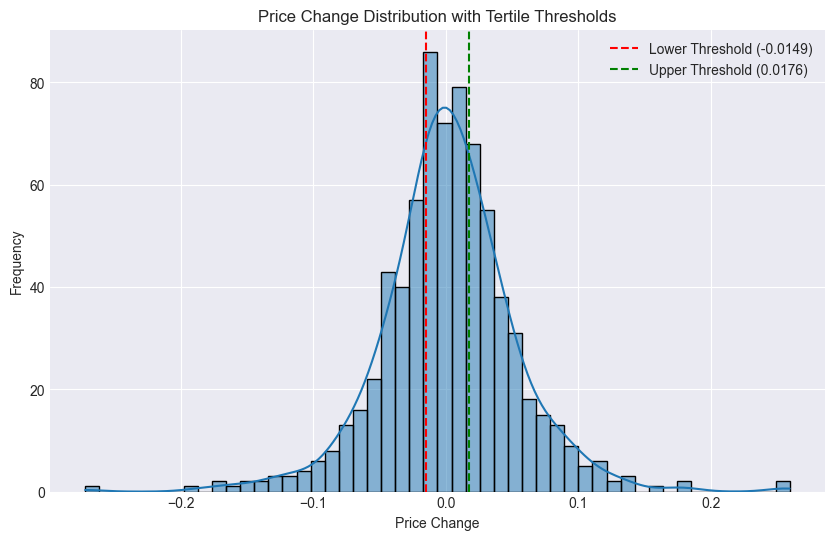

C:\Users\ACER 2\AppData\Local\Temp\ipykernel_27232\396750987.py:171: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  labeled_data[original_features] = labeled_data[original_features].fillna(method='ffill').fillna(method='bfill')


Shape of labeled_data: (730, 23)
Features used: ['whale_avg_valueEth', 'whale_var_valueEth', 'whale_avg_gasPrice', 'validator_count', 'validator_gas_price', 'lag1_delta', 'lag2_delta', 'volatility', 'volume_change', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'obv']
NaNs in labeled_data:
 whale_avg_valueEth     0
whale_var_valueEth     0
whale_avg_gasPrice     0
validator_count        0
validator_gas_price    0
lag1_delta             0
lag2_delta             0
volatility             0
volume_change          0
rsi                    0
macd                   0
bb_upper               0
bb_lower               0
obv                    0
dtype: int64
Training data shape: X=(511, 14), y=(511,)
Testing data shape: X=(219, 14), y=(219,)
Windowed training data shape: X=(507, 5, 14), y=(507,)
Windowed testing data shape: X=(215, 5, 14), y=(215,)

--- Training Base Model: Enhanced TCN ---
Epoch 1/100
2/2 [==============================] - 3s 447ms/step - loss: 2.5808 - accuracy: 0.3333 - val_loss: 1.99

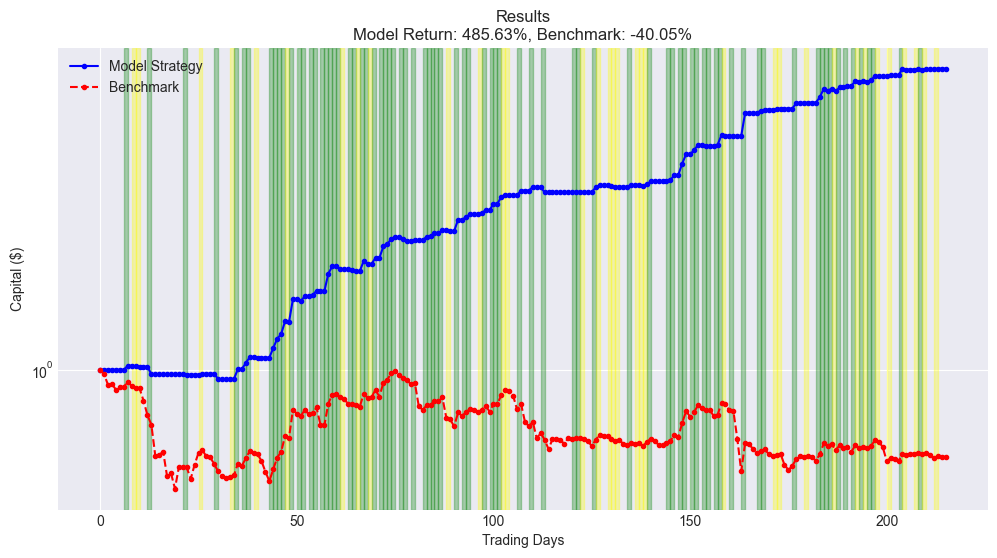


Metrics for Stacking Ensemble ():
Test Accuracy: 0.6047
Test F1 Score: 0.5756
Classification Report:
              precision    recall  f1-score   support

         Low       0.56      0.86      0.68        66
      Medium       0.85      0.31      0.46        93
        High       0.55      0.79      0.65        56

    accuracy                           0.60       215
   macro avg       0.66      0.65      0.60       215
weighted avg       0.69      0.60      0.58       215



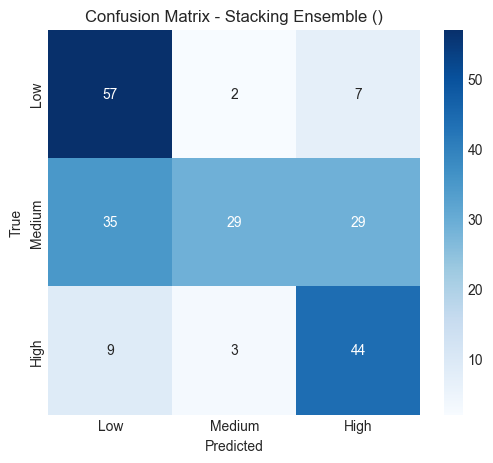

Backtest Results: {'total_return_pct': 485.6262829106471, 'benchmark_return_pct': -40.05477397617972}

Final Results:
  model_name  test_accuracy  test_f1_weighted  backtest_return_pct  \
0  Stacking_         0.6047            0.5756             485.6263   

   benchmark_return_pct  
0              -40.0548  


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, Add, Activation, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.optimizers import AdamW
from tensorflow.keras.optimizers import AdamW
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import ta
import sys
import argparse

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

# Environment detection for Jupyter
def is_jupyter():
    return 'ipykernel' in sys.modules or 'IPython' in sys.modules

# Argument parsing
if not is_jupyter():
    parser = argparse.ArgumentParser(description='Stacking Ensemble for Price Prediction')
    parser.add_argument('--meta-classifier', type=str, default='rf', choices=['rf', 'svm', 'xgb'],
                        help='Meta-classifier: rf (Random Forest), svm (SVM), xgb (XGBoost)')
    parser.add_argument('--verbose', action='store_true', help='Enable verbose output')
    args = parser.parse_args()
    meta_classifier = args.meta_classifier
    verbose = args.verbose
else:
    meta_classifier = ''  # Change here
    verbose = True 

# Data Loading
if verbose:
    print("Fetching data from yfinance...")
try:
    eth_data = yf.download('ETH-USD', start='2021-01-01', end='2023-01-01', interval='1d')
except Exception as e:
    raise RuntimeError(f"Failed to fetch yfinance data: {e}")
eth_data.columns = [col[0] if isinstance(col, tuple) else col for col in eth_data.columns]
price_history_raw = eth_data.reset_index().rename(columns={
    'Date': 'timeOpen', 'Close': 'close', 'Open': 'open',
    'High': 'high', 'Low': 'low', 'Volume': 'volume'
})

# Debugging
if verbose:
    print("price_history_raw columns:", price_history_raw.columns)
    print("price_history_raw['close'] dtype:", price_history_raw['close'].dtype)
    print("price_history_raw shape:", price_history_raw.shape)

# Create price_deltas
price_deltas = price_history_raw[['timeOpen', 'close', 'volume', 'open', 'high', 'low']].copy()
price_deltas['close'] = pd.to_numeric(price_deltas['close'], errors='coerce')
if price_deltas['close'].isna().all():
    raise ValueError("All 'close' values are NaN.")
price_deltas['close'] = price_deltas['close'].interpolate(method='linear', limit_direction='both')
if verbose:
    print("NaNs in 'close':", price_deltas['close'].isna().sum())

# Process timeOpen
price_deltas['timeOpen'] = pd.to_datetime(price_deltas['timeOpen'], errors='coerce')
if price_deltas['timeOpen'].isna().any():
    raise ValueError("Invalid 'timeOpen' values detected.")
price_deltas['date'] = price_deltas['timeOpen'].dt.date

# Calculate price delta
price_deltas['delta'] = price_deltas['close'].pct_change()

# Feature Engineering
price_deltas['lag1_delta'] = price_deltas['delta'].shift(1)
price_deltas['lag2_delta'] = price_deltas['delta'].shift(2)
price_deltas['volatility'] = price_deltas['delta'].rolling(window=7).std()
price_deltas['volume_change'] = price_deltas['volume'].pct_change()
price_deltas['rsi'] = ta.momentum.RSIIndicator(price_deltas['close'], window=14).rsi()
price_deltas['macd'] = ta.trend.MACD(price_deltas['close']).macd()
price_deltas['bb_upper'] = ta.volatility.BollingerBands(price_deltas['close']).bollinger_hband()
price_deltas['bb_lower'] = ta.volatility.BollingerBands(price_deltas['close']).bollinger_lband()
price_deltas['obv'] = ta.volume.OnBalanceVolumeIndicator(price_deltas['close'], price_deltas['volume']).on_balance_volume()

# Fill NaNs in features
feature_cols = ['lag1_delta', 'lag2_delta', 'volatility', 'volume_change', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'obv']
price_deltas[feature_cols] = price_deltas[feature_cols].fillna(method='ffill').fillna(method='bfill')

# Debugging
if verbose:
    print("\nprice_deltas shape:", price_deltas.shape)
    print("price_deltas columns:", price_deltas.columns)
    print("NaNs in features:\n", price_deltas[feature_cols].isna().sum())

# Load Whale/Validator Data
try:
    base_path = r'C:\Users\ACER 2\OneDrive\Documents\178\DATA\\'

    whales = pd.read_csv(base_path + 'transactions_aggregated_21_22.csv')
    validators = pd.read_csv(base_path + 'validators_aggregated_21_22.csv')
except FileNotFoundError as e:
    raise FileNotFoundError(f"Could not find CSV files: {e}")
whales['date'] = pd.to_datetime(whales['datetime'], errors='coerce').dt.date
validators['date'] = pd.to_datetime(validators['datetime'], errors='coerce').dt.date
if whales['date'].isna().any() or validators['date'].isna().any():
    raise ValueError("Invalid dates in whale/validator data.")
if verbose:
    print("\nWhales date range:", whales['date'].min(), "to", whales['date'].max())
    print("Validators date range:", validators['date'].min(), "to", validators['date'].max())

# Label Generation - Updated for 3-class classification
num_labels = 3
price_changes = price_deltas['close'].pct_change()

# Calculate tertile thresholds (33rd and 66th percentiles)
lower_threshold, upper_threshold = np.percentile(price_changes.dropna(), [33, 66])

# Create 3-class labels
price_deltas['labels'] = np.select(
    [
        price_changes < lower_threshold,
        price_changes > upper_threshold,
        (price_changes >= lower_threshold) & (price_changes <= upper_threshold)
    ],
    [0, 2, 1],  # 0=Low, 1=Medium, 2=High
    default=1  # Default to medium if any edge cases
)

if verbose:
    print(f"\nLabel distribution:\n{price_deltas['labels'].value_counts(normalize=True)}")
    print(f"Thresholds: Lower={lower_threshold:.4f}, Upper={upper_threshold:.4f}")
    
    # Visualize the thresholds
    plt.figure(figsize=(10, 6))
    sns.histplot(price_changes.dropna(), bins=50, kde=True)
    plt.axvline(lower_threshold, color='red', linestyle='--', label=f'Lower Threshold ({lower_threshold:.4f})')
    plt.axvline(upper_threshold, color='green', linestyle='--', label=f'Upper Threshold ({upper_threshold:.4f})')
    plt.title('Price Change Distribution with Tertile Thresholds')
    plt.xlabel('Price Change')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Data Aggregation & Merging
whale_aggregated = whales.groupby('date').agg(
    whale_avg_valueEth=('valueETH', 'mean'),
    whale_var_valueEth=('valueETH', 'var'),
    whale_avg_gasPrice=('gasPrice', 'mean')
)
validators_aggregated = validators.groupby('date').agg(
    validator_count=('blockHash', 'nunique'),
    validator_gas_price=('gasPrice', 'mean')
)
_intermediate = pd.merge(price_deltas, whale_aggregated, on='date', how='left')
labeled_data = pd.merge(_intermediate, validators_aggregated, on='date', how='left')
original_features = [
    'whale_avg_valueEth', 'whale_var_valueEth', 'whale_avg_gasPrice',
    'validator_count', 'validator_gas_price', 'lag1_delta', 'lag2_delta',
    'volatility', 'volume_change', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'obv'
]
labeled_data[original_features] = labeled_data[original_features].fillna(method='ffill').fillna(method='bfill')
labeled_data.dropna(subset=['labels'], inplace=True)
labeled_data.sort_values(by='date', inplace=True)
if labeled_data.empty:
    raise ValueError("labeled_data is empty after preprocessing.")
if verbose:
    print(f"Shape of labeled_data: {labeled_data.shape}")
    print(f"Features used: {original_features}")
    print("NaNs in labeled_data:\n", labeled_data[original_features].isna().sum())

# Train/Test Split & Scaling
y = labeled_data['labels'].astype(int)
X = labeled_data[original_features]
if X.shape[0] < 10:
    raise ValueError("Not enough data after merging.")
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_train = pd.DataFrame(X_train, columns=original_features, index=X_train_raw.index)
X_test = pd.DataFrame(X_test, columns=original_features, index=X_test_raw.index)
if verbose:
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")

# Windowing
window_length = 5
input_features = X_train.shape[1]
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)
X_train_windowed = create_windows(X_train.values, window_length)
X_test_windowed = create_windows(X_test.values, window_length)
y_train_windowed = y_train.iloc[window_length-1:].values
y_test_windowed = y_test.iloc[window_length-1:].values
if X_train_windowed.shape[0] != y_train_windowed.shape[0]:
    raise ValueError(f"Training data mismatch: X={X_train_windowed.shape}, y={y_train_windowed.shape}")
if X_test_windowed.shape[0] != y_test_windowed.shape[0]:
    raise ValueError(f"Testing data mismatch: X={X_test_windowed.shape}, y={y_test_windowed.shape}")
if verbose:
    print(f"Windowed training data shape: X={X_train_windowed.shape}, y={y_train_windowed.shape}")
    print(f"Windowed testing data shape: X={X_test_windowed.shape}, y={y_test_windowed.shape}")
num_classes = len(np.unique(y_train_windowed))
price_deltas_test_aligned = labeled_data['delta'].loc[y_test.index[window_length-1:]].to_numpy()
if len(price_deltas_test_aligned) != len(y_test_windowed):
    raise ValueError("Price deltas and test labels length mismatch.")

# Updated Backtesting Function for 3-class system
def calculate_model_returns(predictions, price_deltas, num_labels, invest_on_tie=False, plot_results=True, investment_rate=0.8):
    if len(predictions) != len(price_deltas):
        print(f"Warning: Length mismatch: predictions ({len(predictions)}), price_deltas ({len(price_deltas)})")
        return {'total_return_pct': np.nan, 'benchmark_return_pct': np.nan}
    
    model_history = [1]
    benchmark_history = [1]
    investing_schedule = []
    
    for i in range(len(predictions)):
        if np.isnan(price_deltas[i]):
            benchmark_history.append(benchmark_history[-1])
            model_history.append(model_history[-1])
            investing_schedule.append(0)
            continue
            
        benchmark_history.append(benchmark_history[-1] * (1 + price_deltas[i]))
        
        # Investment logic for 3 classes
        if num_labels == 3:
            if predictions[i] == 2:  # High movement - full investment
                capital_change = model_history[-1] * price_deltas[i] * investment_rate
                model_history.append(model_history[-1] + capital_change)
                investing_schedule.append(1)
            elif predictions[i] == 1:  # Medium movement - half investment
                capital_change = model_history[-1] * price_deltas[i] * (investment_rate/2)
                model_history.append(model_history[-1] + capital_change)
                investing_schedule.append(0.5)
            else:  # Low movement - no investment
                model_history.append(model_history[-1])
                investing_schedule.append(0)
        else:  # Original binary logic (for backward compatibility)
            if predictions[i] == 1:
                capital_change = model_history[-1] * price_deltas[i] * investment_rate
                model_history.append(model_history[-1] + capital_change)
                investing_schedule.append(1)
            else:
                model_history.append(model_history[-1])
                investing_schedule.append(0)
    
    total_return_pct = (model_history[-1] - 1) * 100
    benchmark_return_pct = (benchmark_history[-1] - 1) * 100
    
    if plot_results:
        plt.figure(figsize=(12, 6))
        plt.plot(model_history, label='Model Strategy', color='blue', marker='.')
        plt.plot(benchmark_history, label='Benchmark', color='red', linestyle='--', marker='.')
        
        # Color coding for 3-class investments
        for i, invested in enumerate(investing_schedule):
            if invested == 1:  # Full investment
                plt.axvspan(i, i + 1, color='green', alpha=0.3)
            elif invested == 0.5:  # Partial investment
                plt.axvspan(i, i + 1, color='yellow', alpha=0.3)
                
        plt.title(f'Results\nModel Return: {total_return_pct:.2f}%, Benchmark: {benchmark_return_pct:.2f}%')
        plt.xlabel('Trading Days')
        plt.ylabel('Capital ($)')
        plt.yscale('log')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    return {'total_return_pct': total_return_pct, 'benchmark_return_pct': benchmark_return_pct}

# TCN Model
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.3):
    prev_x = x
    if x.shape[-1] != filters:
        prev_x = Conv1D(filters, kernel_size=1, padding='same', kernel_regularizer=l2(0.01))(prev_x)
    conv1 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(dropout_rate)(conv1)
    conv2 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal', kernel_regularizer=l2(0.01))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    out = Add()([prev_x, conv2])
    out = Activation('relu')(out)
    return out

def build_enhanced_tcn(window_length, input_features, num_classes):
    inputs = Input(shape=(window_length, input_features))
    x = inputs
    for d in [1, 2]:
        x = residual_block(x, filters=16, kernel_size=3, dilation_rate=d)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    return Model(inputs, outputs, name="Enhanced_TCN")

# Transformer Model
def build_transformer(window_length, input_features, num_classes):
    inputs = Input(shape=(window_length, input_features))
    x = inputs
    for _ in range(1):
        attn_output = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
        ffn = Dense(input_features, kernel_regularizer=l2(0.01))(ffn)
        x = LayerNormalization(epsilon=1e-6)(x + ffn)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    return Model(inputs, outputs, name="Transformer")

# Training & Prediction for Base Models
def train_predict_base_model(model_name, model, X_train_data, y_train_data, X_test_data, tscv, model_type='keras', epochs=100, batch_size=64):
    if verbose:
        print(f"\n--- Training Base Model: {model_name} ---")
    train_preds = np.zeros(len(y_train_data))
    test_preds = np.zeros(len(X_test_data))
    fold_test_preds = []
    
    if model_type == 'keras':
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_data)):
            X_tr, X_val = X_train_data[train_idx], X_train_data[val_idx]
            y_tr, y_val = y_train_data[train_idx], y_train_data[val_idx]
            model_fold = tf.keras.models.clone_model(model)
            model_fold.compile(optimizer=AdamW(learning_rate=0.0005), 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
            class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
            class_weight_dict = dict(enumerate(class_weights))
            model_fold.fit(
                X_tr, y_tr, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1 if verbose else 0),
                           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1 if verbose else 0)],
                class_weight=class_weight_dict, verbose=1 if verbose else 0
            )
            train_preds[val_idx] = np.argmax(model_fold.predict(X_val, verbose=0), axis=1)
            fold_test_preds.append(np.argmax(model_fold.predict(X_test_data, verbose=0), axis=1))
        test_preds = np.mean(fold_test_preds, axis=0).round().astype(int)
    else:
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_data)):
            X_tr, X_val = X_train_data[train_idx], X_train_data[val_idx]
            y_tr, y_val = y_train_data[train_idx], y_train_data[val_idx]
            model.fit(X_tr, y_tr)
            train_preds[val_idx] = model.predict(X_val)
            fold_test_preds.append(model.predict(X_test_data))
        test_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=fold_test_preds)
    
    return train_preds, test_preds

# Stacking Ensemble
def train_stacking_ensemble(X_train_windowed, y_train_windowed, X_test_windowed, y_test_windowed, price_deltas_test_aligned, num_labels):
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize base models
    tcn_model = build_enhanced_tcn(window_length, input_features, num_classes)
    transformer_model = build_transformer(window_length, input_features, num_classes)
    xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    
    # Get base model predictions
    tcn_train_preds, tcn_test_preds = train_predict_base_model(
        "Enhanced TCN", tcn_model, X_train_windowed, y_train_windowed, X_test_windowed, tscv
    )
    transformer_train_preds, transformer_test_preds = train_predict_base_model(
        "Transformer", transformer_model, X_train_windowed, y_train_windowed, X_test_windowed, tscv
    )
    xgb_train_preds, xgb_test_preds = train_predict_base_model(
        "XGBoost", xgb_model, X_train_windowed.reshape(X_train_windowed.shape[0], -1),
        y_train_windowed, X_test_windowed.reshape(X_test_windowed.shape[0], -1), tscv, model_type='sklearn'
    )
    
    # Stack predictions
    train_meta_features = np.column_stack((tcn_train_preds, transformer_train_preds, xgb_train_preds))
    test_meta_features = np.column_stack((tcn_test_preds, transformer_test_preds, xgb_test_preds))
    
    # Train meta-classifier
    if meta_classifier == 'rf':
        meta_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    elif meta_classifier == 'svm':
        meta_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
    else:
        meta_model = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
    
    if verbose:
        print(f"\n--- Training Meta-Classifier: {meta_classifier.upper()} ---")
    meta_model.fit(train_meta_features, y_train_windowed)
    
    # Evaluate ensemble
    y_pred = meta_model.predict(test_meta_features)
    accuracy = accuracy_score(y_test_windowed, y_pred)
    f1 = f1_score(y_test_windowed, y_pred, average='weighted')
    class_report = classification_report(y_test_windowed, y_pred, target_names=["Low", "Medium", "High"], zero_division=0)
    conf_matrix = confusion_matrix(y_test_windowed, y_pred)
    backtest_results = calculate_model_returns(y_pred, price_deltas_test_aligned, num_labels)
    
    if verbose:
        print(f"\nMetrics for Stacking Ensemble ({meta_classifier.upper()}):")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        print("Classification Report:")
        print(class_report)
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=["Low", "Medium", "High"],
                    yticklabels=["Low", "Medium", "High"])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - Stacking Ensemble ({meta_classifier.upper()})')
        plt.show()
        print(f"Backtest Results: {backtest_results}")
    
    return {
        'model_name': f'Stacking_{meta_classifier.upper()}',
        'test_accuracy': accuracy,
        'test_f1_weighted': f1,
        'backtest_return_pct': backtest_results.get('total_return_pct', np.nan),
        'benchmark_return_pct': backtest_results.get('benchmark_return_pct', np.nan)
    }

# Run ensemble
try:
    results = train_stacking_ensemble(X_train_windowed, y_train_windowed, X_test_windowed, y_test_windowed, price_deltas_test_aligned, num_labels)
    if verbose:
        print("\nFinal Results:")
        print(pd.DataFrame([results]).round(4))
except Exception as e:
    print(f"Error during execution: {e}")
    raise